In [ ]:
!git clone https://github.com/Atharva309/trash_classification_data.git

Cloning into 'trash_classification_data'...
remote: Enumerating objects: 55212, done.
remote: Counting objects: 100% (6598/6598), done.
remote: Compressing objects: 100% (6557/6557), done.
remote: Total 55212 (delta 39), reused 6598 (delta 39), pack-reused 48614
Receiving objects: 100% (55212/55212), 719.18 MiB | 30.65 MiB/s, done.
Resolving deltas: 100% (46/46), done.
Updating files: 100% (54901/54901), done.


In [ ]:
#deleting unwanted files from dataset
import os

folder_path = '/content/trash_classification_data'

for root, dirs, files in os.walk(folder_path):
    for file in files:
        if file == '.DS_Store':
            os.remove(os.path.join(root, file))


In [ ]:
#searching if directory has files other than .jpg
import os

path = '/content/trash_classification_data/organictrashdetection/TRAIN'

# List all files in the directory
files = os.listdir(path)

# Filter out files that do not end with '.jpg'
non_jpg_files = [file for file in files if not file.endswith('.jpg')]

# Print the number of non-jpg files
print(len(non_jpg_files))

# Print the names of the non-jpg files
print(non_jpg_files)

2
['R', 'O']


In [ ]:
#resize images in new directory
import os
import cv2

source_dir = '/content/trash_classification_data/organictrashdetection/TRAIN'
target_dir = '/content/resized_trash_images'

# Create the target directory if it doesn't exist
if not os.path.exists(target_dir):
    os.makedirs(target_dir)

# Loop through each folder in the source directory
for folder_name in os.listdir(source_dir):
    folder_path = os.path.join(source_dir, folder_name)
    if os.path.isdir(folder_path):
        # Create the corresponding folder in the target directory
        target_folder_path = os.path.join(target_dir, folder_name)
        if not os.path.exists(target_folder_path):
            os.makedirs(target_folder_path)
        
        # Loop through each image in the folder and resize it
        for image_name in os.listdir(folder_path):
            image_path = os.path.join(folder_path, image_name)
            target_image_path = os.path.join(target_folder_path, image_name)
            
            if not os.path.isfile(target_image_path):
                img = cv2.imread(image_path)
                if img is not None:
                    img = cv2.resize(img, (224, 224))
                    cv2.imwrite(target_image_path, img)
                else:
                    print(f"Invalid image: {image_path}")
            else:
                print(f"Skipping image: {image_path}")


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2

# Set the batch size and image dimensions
batch_size = 32
img_height = 224
img_width = 224

# Create an ImageDataGenerator to augment the images and split them into training and validation sets
# train_datagen = ImageDataGenerator(
#     rescale=1./255,
#     rotation_range=20,
#     zoom_range=0.2,
#     shear_range=0.2,
#     horizontal_flip=True,
#     validation_split=0.2,
#     width_shift_range=0.1,
#     height_shift_range=0.1,
#     preprocessing_function=tf.keras.applications.resnet50.preprocess_input
# )
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
    )

train_data = train_datagen.flow_from_directory(
    '/content/resized_trash_images',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training')

val_data = train_datagen.flow_from_directory(
    '/content/resized_trash_images',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation')


# Create a model using a pre-trained ResNet50V2 network
base_model = keras.applications.ResNet50V2(weights='imagenet',
                                           include_top=False,
                                           input_shape=(img_height, img_width, 3))

# Freeze the weights of the pre-trained layers so they are not updated during training
for layer in base_model.layers:
    layer.trainable = False

# Add a new classification layer to the top of the pre-trained network
x = base_model.output
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(1024, activation='relu', kernel_regularizer=l2(0.01))(x)
x = keras.layers.Dropout(0.5)(x)
predictions = keras.layers.Dense(train_data.num_classes, activation='softmax')(x)
model = keras.Model(inputs=base_model.input, outputs=predictions)

# Compile the model with an optimizer, loss function, and evaluation metric
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Define early stopping callback to monitor validation loss and stop training if it doesn't improve for 3 epochs
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# Train the model on the training data and validate it on the validation data
model.fit(train_data,
          validation_data=val_data,
          epochs=15,
          steps_per_epoch=train_data.samples // batch_size,
          validation_steps=val_data.samples // batch_size,
          callbacks=[early_stop])


Found 18052 images belonging to 2 classes.
Found 4512 images belonging to 2 classes.
9406464/9406464 [==============================] - 0s 0us/step
Epoch 1/50
564/564 [==============================] - 1148s 2s/step - loss: 1.9868 - accuracy: 0.8721 - val_loss: 0.4520 - val_accuracy: 0.9353
Epoch 2/50
564/564 [==============================] - 1154s 2s/step - loss: 0.4989 - accuracy: 0.8895 - val_loss: 0.4889 - val_accuracy: 0.8737
Epoch 3/50
564/564 [==============================] - 1131s 2s/step - loss: 0.4564 - accuracy: 0.8923 - val_loss: 0.3543 - val_accuracy: 0.9335
Epoch 4/50
564/564 [==============================] - 1121s 2s/step - loss: 0.4462 - accuracy: 0.8948 - val_loss: 0.3882 - val_accuracy: 0.9100
Epoch 5/50
564/564 [==============================] - 1116s 2s/step - loss: 0.4215 - accuracy: 0.8975 - val_loss: 0.3936 - val_accuracy: 0.9047
Epoch 6/50
564/564 [==============================] - 1112s 2s/step - loss: 0.4295 - accuracy: 0.8940 - val_loss: 0.3474 - val_accur

In [ ]:
# Save the trained model 
model.save('/content/trash_image_classifier_resnet_O-R.h5')

In [ ]:
from google.colab import files

# Download the saved model weights file
files.download('/content/trash_image_classifier_resnet_O-R.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

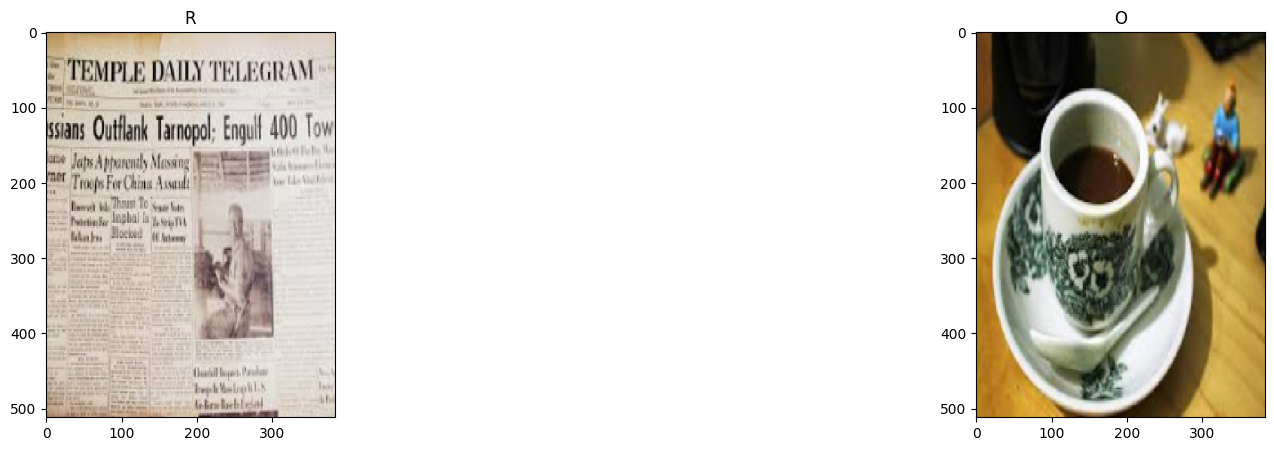

In [ ]:
# Import the required libraries
import os
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# Define the directory path and subdirectories
base_dir = '/content/resized_trash_images'

# Get the class names
class_names = os.listdir(base_dir)

# Display an example image from each class in the training set
fig, axes = plt.subplots(nrows=1, ncols=len(class_names), figsize=(20, 5))
fig.subplots_adjust(wspace=0.5)
for i, class_name in enumerate(class_names):
    img_path = os.path.join(base_dir, class_name, os.listdir(os.path.join(base_dir, class_name))[0])
    img = image.load_img(img_path, target_size=(512, 384))
    axes[i].imshow(img)
    axes[i].set_title(class_name)
plt.show()


In [ ]:
#ONLY RUN IF YOU WANT TO DELETE RESIZED FOLDER

import shutil
import os

# Define the path of the folder to delete
folder_path = '/content/resized_trash_images'
# Use shutil.rmtree() to delete the folder and all its contents
shutil.rmtree(folder_path)